In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


hidden-mind-321019

# ::::PROJECT OBJECTIVES::::
1] Application of NLP techniques to find whether two questions have the same meaning or not,so that they do not need to be reanswered.
2] Concepts of feature engineering in inventing new features from the data that we have,like we devised many new features in the project.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

IMPORTANT NOTE: as the the notebook has only 16 gb ram we have taken only 25 percent of the data that is roughly 100000 data points.(It was tried to run the model with te complete data but the ram crashed.)

In [4]:
df = pd.read_csv('../input/quora-question-pairs/train.csv.zip')
dx=df.head(100000)
dy=df.head(100000)
dt=df.head(100000)
print("Number of data points:",dx.shape[0])
dx.head()
dx.info()

Number of data points: 100000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  int64 
 1   qid1          100000 non-null  int64 
 2   qid2          100000 non-null  int64 
 3   question1     100000 non-null  object
 4   question2     100000 non-null  object
 5   is_duplicate  100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


In [5]:
dx

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
99995,99995,165922,165923,What are some of the most iconic images of foo...,What are some of the most iconic images of women?,0
99996,99996,165924,165925,How green is green tea?,"Why isn't ""green"" tea green?",0
99997,99997,165926,165927,Who would win: Black Panther or Batman?,Who would win in a fight between Black Panther...,1
99998,99998,165928,165929,"Which school is better, for what, and why: Par...",What are some good design schools/colleges on ...,0


In [6]:
dx.info()
print('Total number of question pairs for training:\n   {}'.format(len(dx)))
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(dx['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(dx['is_duplicate'].mean()*100, 2)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  int64 
 1   qid1          100000 non-null  int64 
 2   qid2          100000 non-null  int64 
 3   question1     100000 non-null  object
 4   question2     100000 non-null  object
 5   is_duplicate  100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.6+ MB
Total number of question pairs for training:
   100000
~> Question pairs are not Similar (is_duplicate = 0):
   62.75%

~> Question pairs are Similar (is_duplicate = 1):
   37.25%


In [7]:
qids = pd.Series(dx['qid1'].tolist() + dx['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 
q_vals=qids.value_counts()
q_vals=q_vals.values

Total number of  Unique Questions are: 165931

Number of unique questions that appear more than one time: 19446 (11.719329118730075%)

Max number of times a single question is repeated: 32



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



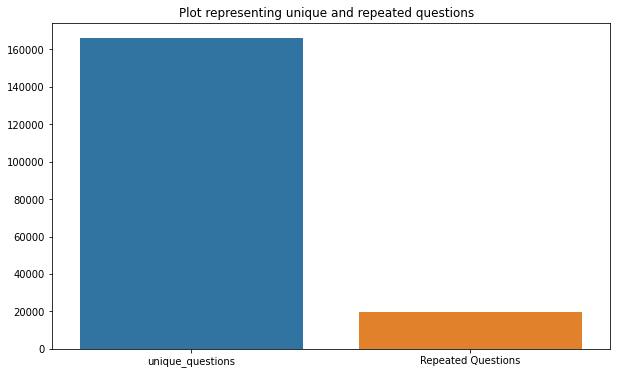

In [8]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [9]:
pair_duplicates = dx[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - dx.shape[0])

Number of duplicate questions 0


Here using EDA techniques we have plotted the frequency vs number of data points plot.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:

The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



Maximum number of times a single question is repeated: 32



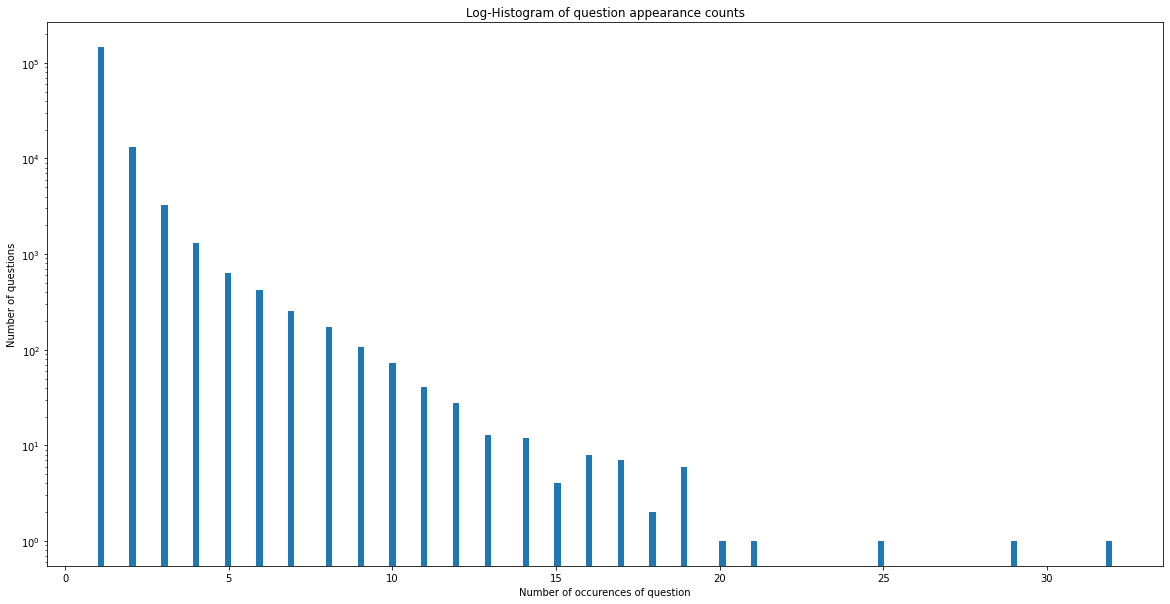

In [10]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [11]:
nan_rows = dx[dx.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [12]:
dx.fillna(' ',inplace=True)
dx['question1'].astype(str)
dx['question2'].astype(str)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0        What is the step by step guide to invest in sh...
1        What would happen if the Indian government sto...
2        How can Internet speed be increased by hacking...
3        Find the remainder when [math]23^{24}[/math] i...
4                  Which fish would survive in salt water?
                               ...                        
99995    What are some of the most iconic images of women?
99996                         Why isn't "green" tea green?
99997    Who would win in a fight between Black Panther...
99998    What are some good design schools/colleges on ...
99999    What would inhaling carbon dioxide cause to a ...
Name: question2, Length: 100000, dtype: object

**HERE I HAVE DEVISED SOME NEW FEATURES ALONG WITH THE ORIGINAL DATA THESE CAN ALSO PROVE TO BE BENEFICIAL::**

1.freq_qid1 = Frequency of qid1's

2.freq_qid2 = Frequency of qid2's

3.q1len = Length of q1

4.q2len = Length of q2

5.q1_n_words = Number of words in Question 1

6.q2_n_words = Number of words in Question 2

7.word_Common = (Number of common unique words in Question 1 and Question 2)

8.word_Total =(Total num of words in Question 1 + Total num of words in Question 2)

9.word_share = (word_common)/(word_Total)

10.freq_q1+freq_q2 = sum total of frequency of qid1 and qid2

11.freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [13]:

    dx['freq_qid1'] = dx.groupby('qid1')['qid1'].transform('count') 
    dx['freq_qid2'] = dx.groupby('qid2')['qid2'].transform('count')
    dx['q1len'] = dx['question1'].str.len() 
    dx['q2len'] = dx['question2'].str.len()
    dx['q1_n_words'] = dx['question1'].apply(lambda row: len(row.split(" ")))
    dx['q2_n_words'] = dx['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    dx['word_Common'] = dx.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    dx['word_Total'] = dx.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    dx['word_share'] = dx.apply(normalized_word_share, axis=1)

    dx['freq_q1+q2'] = dx['freq_qid1']+dx['freq_qid2']
    dx['freq_q1-q2'] = abs(dx['freq_qid1']-dx['freq_qid2'])
    
    dx.to_csv("df_fe_without_preprocessing_train.csv",index=False)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

EDA ANALYSIS OF WORD SHARE USING BOX-PLOTS AND DISTRIBUTIONS WE CAN SEE THAT THIS FEATURE PROVIDES A LITTLE SEPERABILITY SO WE CAN INCLUDE THIS FEATURE.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



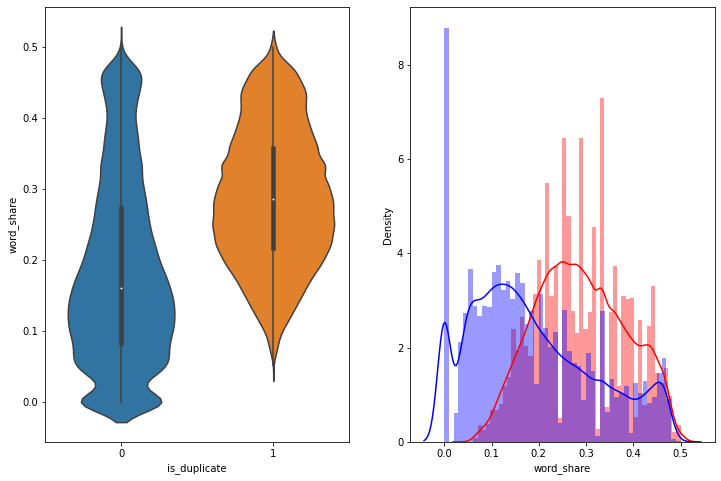

In [14]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = dx[0:])
plt.subplot(1,2,2)
sns.distplot(dx[dx['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(dx[dx['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

WHEREAS IN WORD COMMON FEATURE WE CAN SEE SEPERABILITY ONLY IN THE VIOLIN PLOT.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



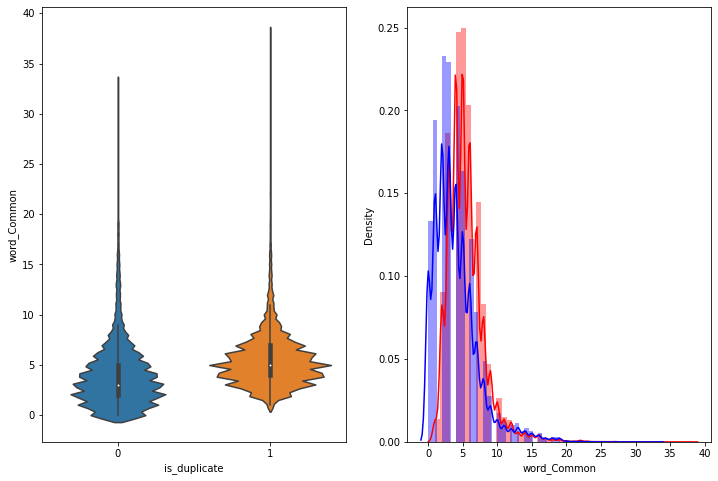

In [15]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = dx[0:])
plt.subplot(1,2,2)
sns.distplot(dx[dx['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(dx[dx['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

**NLP PREPROCESSING**
One of the most important steps before we make complex feature that we will devise.
process includes:-
1. Expanding contractions
2. Removal of non english characters.
3. Stemming of the word(to remove the tense),removal of stopwords.


In [16]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [17]:
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

3.5 Advanced Feature Extraction (NLP and Fuzzy Features)

Features:

cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
last_word_eq : Check if First word of both questions is equal or not
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
first_word_eq : Check if First word of both questions is equal or not
first_word_eq = int(q1_tokens[0] == q2_tokens[0])
abs_len_diff : Abs. length difference
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
mean_len : Average Token Length of both Questions
mean_len = (len(q1_tokens) + len(q2_tokens))/2

FUZZ FEATURES ALSO:-fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_sort_ratio,token_set_ratio
All these features cav be visualised from the data that we have.

In [18]:
preprocess(dx)

'id    qid1    qid2    0          0       1       2    1          1       3       4    2          2       5       6    3          3       7       8    4          4       9      10                                    99995  99995  165922  165923    99996  99996  165924  165925    99997  99997  165926  165927    99998  99998  165928  165929    99999  99999  165930  165931                                                    question1    0      what is the step by step guide to invest in sh       1      what is the story of kohinoor  koh i noor  dia       2      how can i increase the speed of my internet co       3      why am i mentally very lonely  how can i solve       4      which one dissolve in water quikly sugar  salt                                                                   99995  what are some of the most iconic images of foo       99996                            how green is green tea     99997            who would win  black panther or batman     99998  which school is b

In [19]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    common_word_count = len(q1_words.intersection(q2_words))
    
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features



def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
   
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
   
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [20]:
dx = extract_features(dx)
dx.to_csv("nlp_features_train.csv", index=False)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



token features...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

fuzzy features..


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,...,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75


Here we can see that we have used EDA techniques to get pair-plots to understand the usefulness of new features that were created.

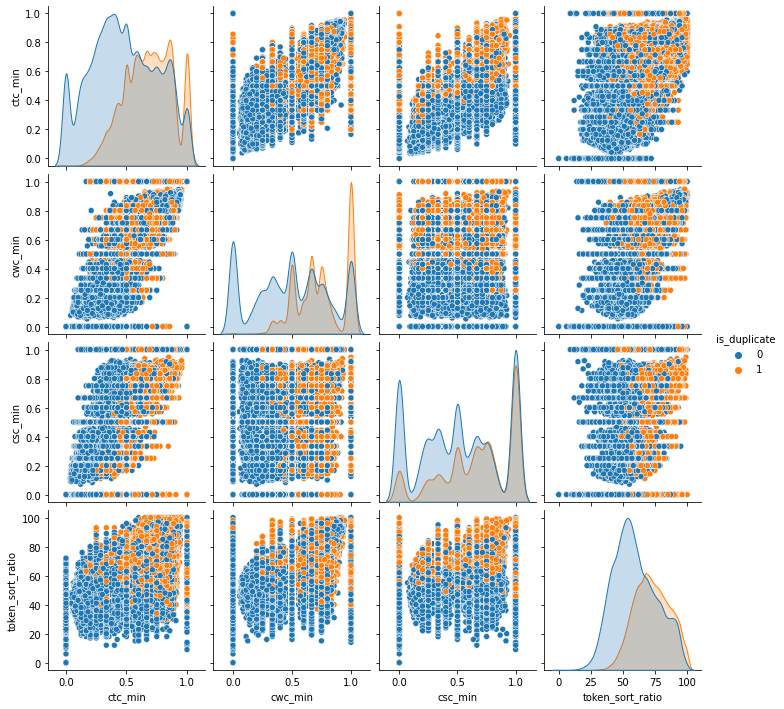

In [21]:
n = dx.shape[0]
sns.pairplot(dx[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()


The graphs have good seperability as we can see here and its not randomized so these features are going to be very useful in finding dupicates.

Violin plot of token sort ratio:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



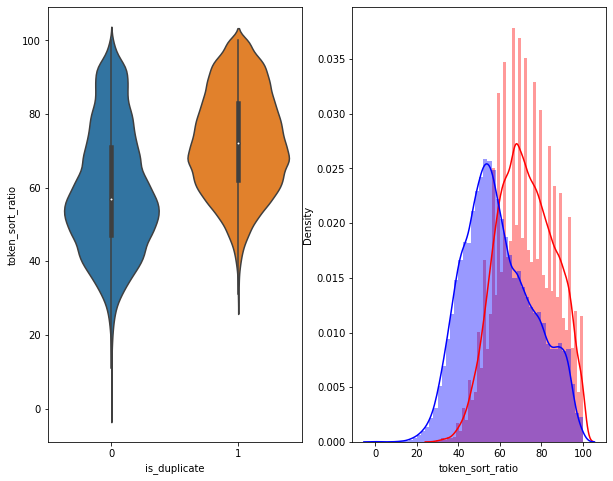

In [22]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = dx[0:] , )
plt.subplot(1,2,2)
sns.distplot(dx[dx['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(dx[dx['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [ ]:
Violin plot of fuzz ratio:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



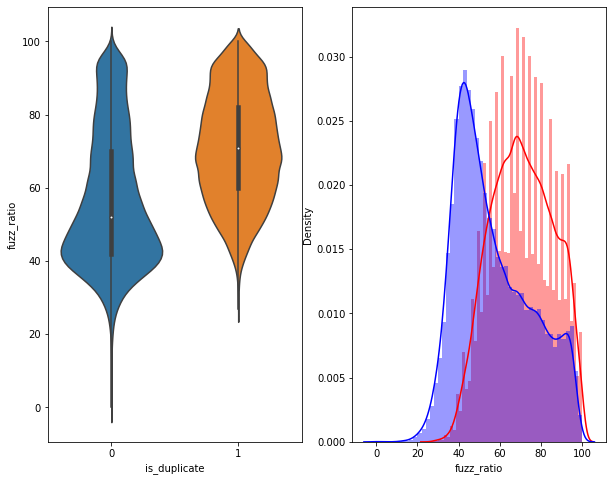

In [23]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = dx[0:] , )
plt.subplot(1,2,2)
sns.distplot(dx[dx['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(dx[dx['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

GOOD SEPERABILITY CAN BE SEEN IN DUSTRIBUITION PLOTS

In [24]:
dx.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,...,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,1,1,76,39,...,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56


In [25]:
dq=dx.copy()

In [48]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = dq[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [51]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 0.356s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.106532
[t-SNE] Computed conditional probabilities in 0.311s
[t-SNE] Iteration 50: error = 80.9503021, gradient norm = 0.0437746 (50 iterations in 1.532s)
[t-SNE] Iteration 100: error = 70.0618057, gradient norm = 0.0093137 (50 iterations in 1.148s)
[t-SNE] Iteration 150: error = 68.1244965, gradient norm = 0.0063670 (50 iterations in 1.149s)
[t-SNE] Iteration 200: error = 67.0610962, gradient norm = 0.0041058 (50 iterations in 1.161s)
[t-SNE] Iteration 250: error = 66.5230942, gradient norm = 0.0030950

/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:580: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



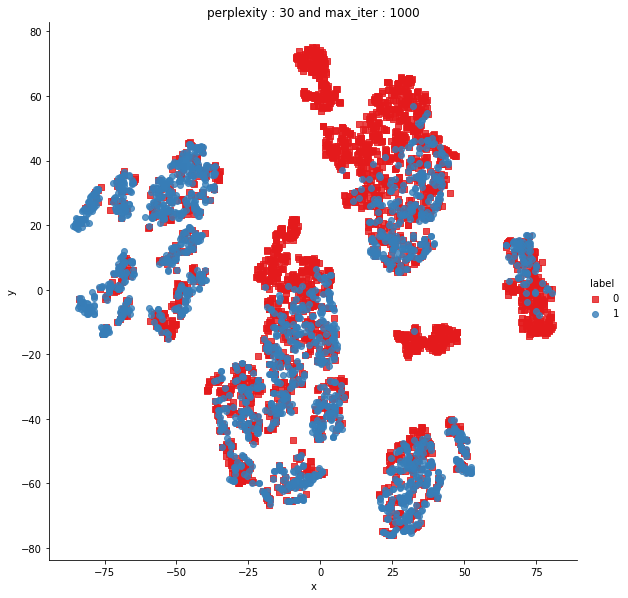

In [52]:
dq = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})
sns.lmplot(data=dq, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

Here by using TSNE we can see the new features in just two dimension and thhere are somr areas of seperability for the machine to learn.

In [58]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.356s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.106532
[t-SNE] Computed conditional probabilities in 0.312s
[t-SNE] Iteration 50: error = 79.9318771, gradient norm = 0.0285540 (50 iterations in 5.415s)
[t-SNE] Iteration 100: error = 68.5272598, gradient norm = 0.0033035 (50 iterations in 2.917s)
[t-SNE] Iteration 150: error = 66.9264832, gradient norm = 0.0017641 (50 iterations in 2.729s)
[t-SNE] Iteration 200: error = 66.3069763, gradient norm = 0.0012502 (50 iterations in 2.612s)
[t-SNE] Iteration 250: error = 65.9567795, gradient norm = 0.0009038

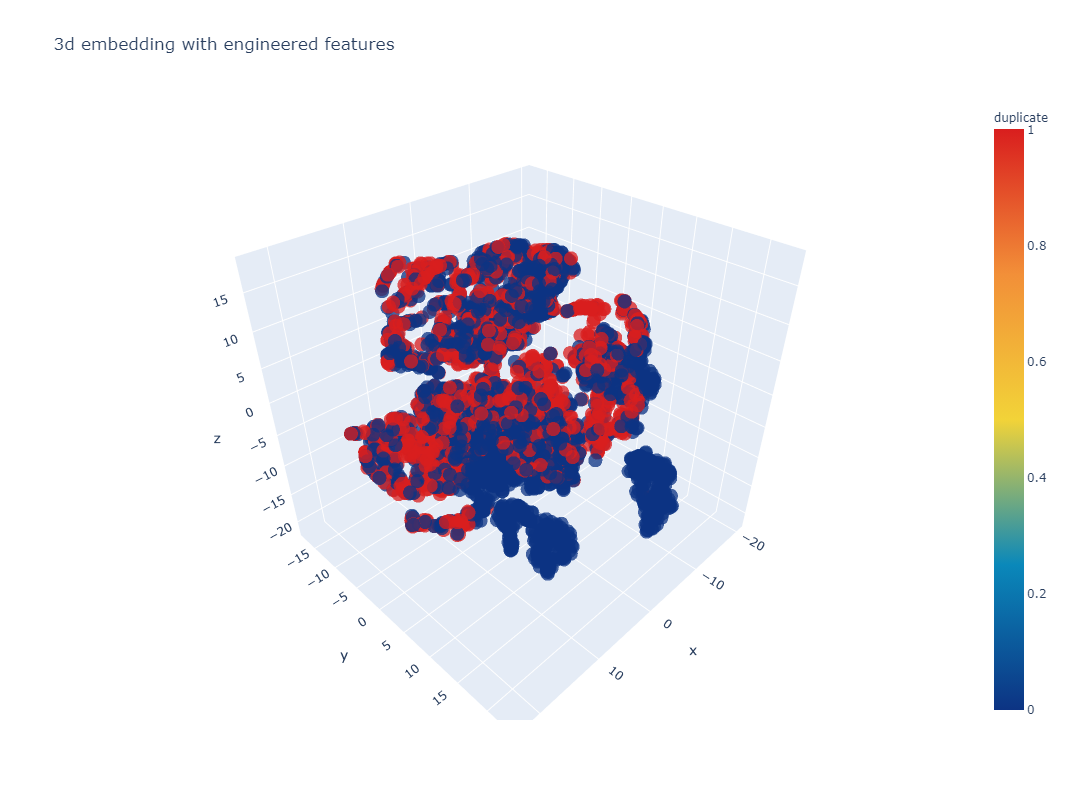

In [59]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

Visualization of TSNE in 3-dimensions we can see there are many densities where points can be seperable.

# IMPLEMENTATION OF TFIDF-WEIGHTED WORD2VEC


In [26]:
dy['question1'] = dy['question1'].apply(lambda x: str(x))
dy['question2'] = dy['question2'].apply(lambda x: str(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
questions = list(dy['question1']) + list(dy['question2'])
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [28]:
import spacy
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')
vecs1 = []

for qu1 in tqdm(list(dy['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        vec1 = word1.vector
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
dy['q1_feats_m'] = list(vecs1)


100%|██████████| 100000/100000 [15:42<00:00, 106.06it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
vecs2 = []
for qu2 in tqdm(list(dy['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        vec2 = word2.vector
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
dy['q2_feats_m'] = list(vecs2)

100%|██████████| 100000/100000 [15:45<00:00, 105.82it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')


In [31]:
dx['q1_feats_m']=list(vecs1)
dx['q2_feats_m']=list(vecs2)
dx.head()
dx.reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,q1_feats_m,q2_feats_m
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,...,0.0,1.0,2.0,13.0,100,93,93,100,"[78.61628606915474, 88.02871969714761, 78.0851...","[69.97938850522041, 62.51671905070543, 65.7828..."
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,...,0.0,1.0,5.0,12.5,86,63,66,75,"[98.24732565879822, 53.77508798241615, -1.8255...","[98.22083926200867, 59.7946794629097, 113.3691..."
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,...,0.0,1.0,4.0,12.0,66,66,54,54,"[63.24868482351303, 72.96814435720444, 10.9195...","[29.434930622577667, 0.1326579451560974, -8.99..."
3,3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,...,0.0,0.0,2.0,12.0,36,36,35,40,"[34.697100892663, -40.16329404711723, 53.29233...","[22.63146996498108, -22.062007069587708, 18.09..."
4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,1,1,76,...,0.0,1.0,6.0,10.0,67,47,46,56,"[130.35090845823288, 184.8101396560669, 141.07...","[1.1050300598144531, 28.77203130722046, 65.851..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,99995,165922,165923,what are some of the most iconic images of foo...,what are some of the most iconic images of women,0,1,1,52,...,0.0,1.0,0.0,10.0,93,85,89,90,"[48.86888764798641, 46.590815246105194, 12.694...","[51.6697203963995, 83.25065726041794, 22.74634..."
99996,99996,99996,165924,165925,how green is green tea,why is not green tea green,0,1,1,23,...,0.0,0.0,1.0,5.5,86,75,60,65,"[46.70116223394871, -33.64850640296936, -12.17...","[80.25596928596497, 10.427495956420898, -10.10..."
99997,99997,99997,165926,165927,who would win black panther or batman,who would win in a fight between black panther...,1,1,1,39,...,1.0,1.0,4.0,9.0,96,74,76,69,"[31.848583459854126, 40.330121010541916, 25.48...","[46.87248069047928, 60.194194465875626, 40.622..."
99998,99998,99998,165928,165929,which school is better for what and why par...,what are some good design schools colleges on ...,0,1,1,59,...,1.0,0.0,0.0,11.0,58,58,46,46,"[52.14076691865921, 26.558108806610107, 71.584...","[75.05581450462341, 76.78751762211323, 35.0813..."


In [32]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dx.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [33]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])


Number of features in nlp dataframe : 27
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 231


In [34]:
df3_q1['id']=df1['id']
df3_q2['id']=df1['id']
df1  = df1.merge(df2, on='id',how='left')
df2  = df3_q1.merge(df3_q2, on='id',how='left')
result  = df1.merge(df2, on='id',how='left')
result.to_csv('final_features.csv')

In [35]:
y_true=dt['is_duplicate']
y_true

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    1
99998    0
99999    0
Name: is_duplicate, Length: 100000, dtype: int64

In [36]:
dx

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,q1_feats_m,q2_feats_m
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.0,1.0,2.0,13.0,100,93,93,100,"[78.61628606915474, 88.02871969714761, 78.0851...","[69.97938850522041, 62.51671905070543, 65.7828..."
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,...,0.0,1.0,5.0,12.5,86,63,66,75,"[98.24732565879822, 53.77508798241615, -1.8255...","[98.22083926200867, 59.7946794629097, 113.3691..."
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.0,1.0,4.0,12.0,66,66,54,54,"[63.24868482351303, 72.96814435720444, 10.9195...","[29.434930622577667, 0.1326579451560974, -8.99..."
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.0,0.0,2.0,12.0,36,36,35,40,"[34.697100892663, -40.16329404711723, 53.29233...","[22.63146996498108, -22.062007069587708, 18.09..."
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,1,1,76,39,...,0.0,1.0,6.0,10.0,67,47,46,56,"[130.35090845823288, 184.8101396560669, 141.07...","[1.1050300598144531, 28.77203130722046, 65.851..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,165922,165923,what are some of the most iconic images of foo...,what are some of the most iconic images of women,0,1,1,52,49,...,0.0,1.0,0.0,10.0,93,85,89,90,"[48.86888764798641, 46.590815246105194, 12.694...","[51.6697203963995, 83.25065726041794, 22.74634..."
99996,99996,165924,165925,how green is green tea,why is not green tea green,0,1,1,23,28,...,0.0,0.0,1.0,5.5,86,75,60,65,"[46.70116223394871, -33.64850640296936, -12.17...","[80.25596928596497, 10.427495956420898, -10.10..."
99997,99997,165926,165927,who would win black panther or batman,who would win in a fight between black panther...,1,1,1,39,58,...,1.0,1.0,4.0,9.0,96,74,76,69,"[31.848583459854126, 40.330121010541916, 25.48...","[46.87248069047928, 60.194194465875626, 40.622..."
99998,99998,165928,165929,which school is better for what and why par...,what are some good design schools colleges on ...,0,1,1,59,60,...,1.0,0.0,0.0,11.0,58,58,46,46,"[52.14076691865921, 26.558108806610107, 71.584...","[75.05581450462341, 76.78751762211323, 35.0813..."


In [37]:
gf=pd.read_csv('final_features.csv')
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(gf, y_true,stratify=y_true,test_size=0.3)

In [38]:
test_len=y_true.shape[0]

In [39]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)


Number of data points in train data : (70000, 231)
Number of data points in test data : (30000, 231)


In [40]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


In [41]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Making a random model first to analyze the credibility of real models that will be made.

Log loss on Test Data using Random Model 0.8834717700334196


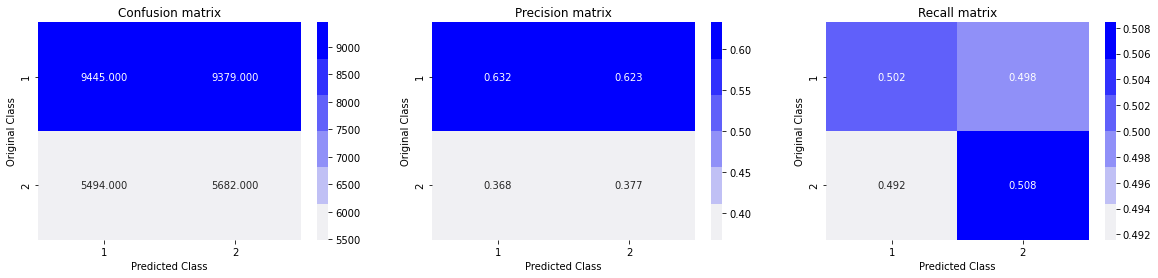

In [42]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# MACHINE LEARNING MODELS
**Logistic Regression with SGD classiifier and Hyperparameter Tuning with cross-validation.**

For values of alpha =  1e-05 The log loss is: 0.6602902116604962
For values of alpha =  0.0001 The log loss is: 0.6602902116604962
For values of alpha =  0.001 The log loss is: 0.6602902116604962
For values of alpha =  0.01 The log loss is: 0.6602902116604962
For values of alpha =  0.1 The log loss is: 0.5849330141417157
For values of alpha =  1 The log loss is: 0.5777350014340558
For values of alpha =  10 The log loss is: 0.6025316869647216


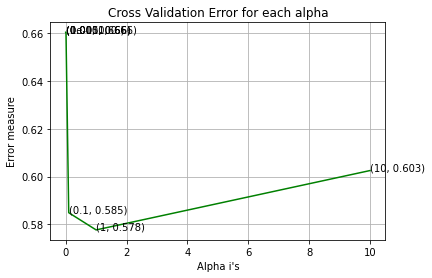

For values of best alpha =  1 The train log loss is: 0.5765382842825607
For values of best alpha =  1 The test log loss is: 0.5747083048279742
Total number of data points : 30000


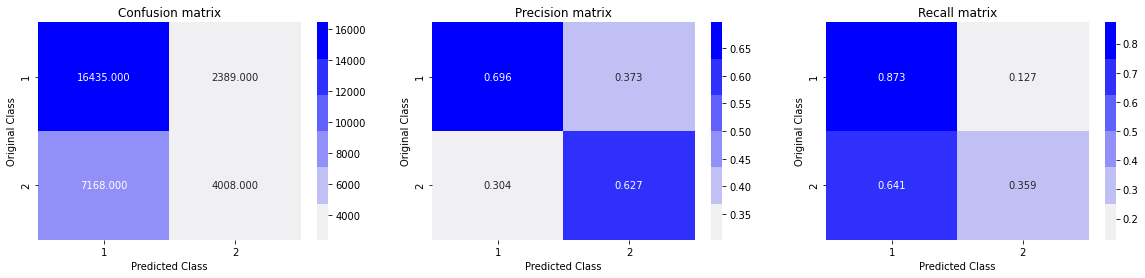

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 2)] 
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Here we get an elbow curve and logistic regression works not that good but still much better than random model that we generated,so random model is a threshold for us.

# GRADIENT BOOSTING CLASSIFIER MODEL

I have used xgboost here due to its better implementation than sklearn.

In [45]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.67349	valid-logloss:0.67334
[10]	train-logloss:0.51172	valid-logloss:0.51172
[20]	train-logloss:0.39689	valid-logloss:0.39684
[30]	train-logloss:0.31197	valid-logloss:0.31192
[40]	train-logloss:0.24754	valid-logloss:0.24753
[50]	train-logloss:0.19775	valid-logloss:0.19775
[60]	train-logloss:0.15885	valid-logloss:0.15882
[70]	train-logloss:0.12806	valid-logloss:0.12806
[80]	train-logloss:0.10357	valid-logloss:0.10358
[90]	train-logloss:0.08398	valid-logloss:0.08398
[100]	train-logloss:0.06823	valid-logloss:0.06822
[110]	train-logloss:0.05549	valid-logloss:0.05550
[120]	train-logloss:0.04521	valid-logloss:0.04521
[130]	train-logloss:0.03686	valid-logloss:0.03686
[140]	train-logloss:0.03009	valid-logloss:0.03008
[150]	train-logloss:0.02457	valid-logloss:0.02457
[160]	train-logloss:0.02007	valid-logloss:0.02007
[170]	train-logloss:0.01641	valid-logloss:0.01641
[180]	train-logloss:0.01342	valid-logloss:0.01342
[190]	train-logloss:0.01098	valid-logloss:0.01098
[200]	train

Total number of data points : 30000


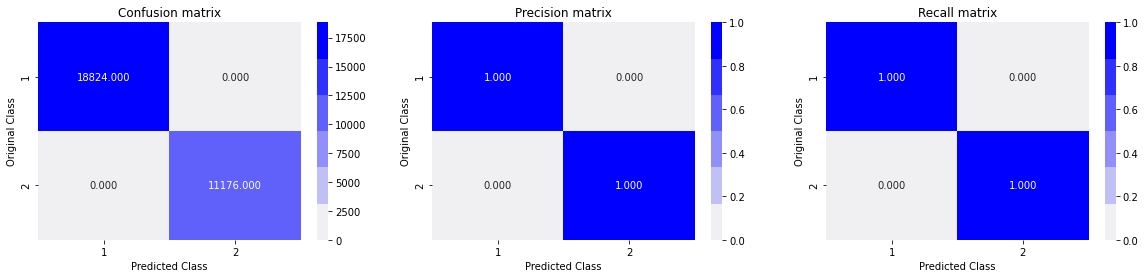

In [46]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**THIS MODEL HAS A VERY LESS LOG-LOSS AND NO MISCLASSIFIED POINT,but this model when run on the complete data points(4lakh) will not show this much performace but still this model will be the best.**
